# Churn Prediction (Telco)

Ce projet faire suite au projet **Customer Churn** de mon repository [https://github.com/soboure69/Customer-Churn](https://github.com/soboure69/Customer-Churn). Mais mon objectif est différent ici, au lieu d'utiliser **Logistic Regression** pour prédire le churn, nous allons utiliser **Random Forest** et **XGBoost**.

## Objectif
Prédire le churn client et comparer **Random Forest** vs **XGBoost**.

## Pourquoi RandomForest et XGBoost (et pas d’autres) ?

### Raisons “recruteur + industrie”
- XGBoost est un standard pour les données tabulaires : très performant, robuste, souvent un top baseline en entreprise.
- RandomForest est un excellent modèle “référence” :
  - rapide à comprendre
  - stable
  - donne une interprétabilité simple via ``feature_importances_``

En comparant les deux, on montre :

- ensemble bagging (RandomForest) vs boosting (XGBoost)
- capacité à faire du tuning + évaluation ROC-AUC

### Raisons pédagogiques
Apprendre les notions clés :

- probabilités ``predict_proba`` → seuil
- métriques (precision/recall)
- importance des variables
- validation croisée / GridSearchCV

## Pourquoi pas Logistic Regression / SVM / Neural Net ?
- Logistic Regression : très utile, mais moins “impressionnant” seul.
- SVM : souvent moins pratique sur gros datasets/tabulaire mixte, tuning plus délicat.
- Réseaux neuronaux tabulaires : rarement meilleur qu’un bon boosting pour ce type de dataset, et plus complexe (pas idéal au début).



## 1) Imports & Setup

In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# VS Code notebooks run from the notebook's folder by default.
# Add the project root (01_ML_Classique_Churn/) to PYTHONPATH so `from src...` works.
PROJECT_DIR = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_DIR))

from src.data_processing import ChurnDataProcessor
from src.model_training import ChurnModelTrainer
from src.evaluation import ChurnModelEvaluator

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 200)
PROJECT_DIR

WindowsPath('C:/Users/bello/Documents/data-science-portfolio/01_ML_Classique_Churn')

## 2) Charger les données

In [2]:
DATA_PATH = PROJECT_DIR / 'data' / 'raw' / 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
DATA_PATH

WindowsPath('C:/Users/bello/Documents/data-science-portfolio/01_ML_Classique_Churn/data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
processor = ChurnDataProcessor(DATA_PATH)
df = processor.load()
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3) EDA rapide (sanity checks)

In [4]:
df.shape

(7043, 21)

In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
df.isna().sum().sort_values(ascending=False).head(15)


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [7]:
df['Churn'].value_counts(dropna=False)


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [8]:
(df['Churn'].value_counts(normalize=True) * 100).round(2)


Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64

## 4) Préprocessing + Feature Engineering

In [9]:
df_clean = processor.clean()
df_fe = processor.feature_engineering()
df_encoded = processor.encode_categorical()
df_encoded.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,monthly_to_total_ratio
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0,0,0.967585
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0,2,0.030124
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1,0,0.493358
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0,2,0.022967
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1,0,0.463151


In [10]:
prepared = processor.prepare_for_modeling()
prepared.X_train.shape, prepared.X_test.shape


((5634, 21), (1409, 21))

## 5) Entraînement (RandomForest + XGBoost)

In [11]:
trainer = ChurnModelTrainer(prepared.X_train, prepared.y_train)
trained = trainer.train_both()
list(trained.models.keys())


c:\Users\bello\Documents\data-science-portfolio\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1137: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


['RandomForest', 'XGBoost']

## 6) Évaluation + sauvegarde des résultats

In [12]:
evaluator = ChurnModelEvaluator(trained.models, prepared.X_test, prepared.y_test)
results = evaluator.evaluate_all()
{k: vars(v) for k, v in results.items()}


{'RandomForest': {'accuracy': 0.7991483321504613,
  'precision': 0.6552901023890785,
  'recall': 0.5133689839572193,
  'f1': 0.5757121439280359,
  'roc_auc': 0.8414348084424812,
  'confusion_matrix': [[934, 101], [182, 192]]},
 'XGBoost': {'accuracy': 0.7977288857345636,
  'precision': 0.6478405315614618,
  'recall': 0.5213903743315508,
  'f1': 0.5777777777777777,
  'roc_auc': 0.842213697073032,
  'confusion_matrix': [[929, 106], [179, 195]]}}

In [13]:
RESULTS_DIR = PROJECT_DIR / 'results'
RESULTS_DIR


WindowsPath('C:/Users/bello/Documents/data-science-portfolio/01_ML_Classique_Churn/results')

In [14]:
import importlib
import src.evaluation
importlib.reload(src.evaluation)
from src.evaluation import ChurnModelEvaluator

## 7) Feature Importance (RandomForest + XGBoost)

On sauvegarde un graphique `feature_importance.png` dans `results/`.

In [20]:
import pandas as pd
from PIL import Image, ImageDraw, ImageFont

# Generate feature_importance.png WITHOUT matplotlib (workaround for RecursionError on some Windows/VS Code setups).

rows = []
for name, model in trained.models.items():
    if not hasattr(model, "feature_importances_"):
        continue
    importances = model.feature_importances_
    for feat, imp in zip(prepared.feature_names, importances, strict=False):
        rows.append({"model": name, "feature": feat, "importance": float(imp)})

fi = pd.DataFrame(rows)
fi_top = (
    fi.sort_values(["model", "importance"], ascending=[True, False])
      .groupby("model")
      .head(15)
)

# Canvas config
W, H = 1400, 700
M = 40
PANEL_GAP = 60
PANEL_W = (W - 2 * M - PANEL_GAP) // 2
PANEL_H = H - 2 * M

bg = (255, 255, 255)
fg = (20, 20, 20)
bar = (31, 119, 180)

a = Image.new("RGB", (W, H), bg)
draw = ImageDraw.Draw(a)

# Font (fallback to default if not found)
try:
    font = ImageFont.truetype("arial.ttf", 16)
    font_title = ImageFont.truetype("arial.ttf", 20)
except Exception:
    font = ImageFont.load_default()
    font_title = ImageFont.load_default()

# Title
draw.text((M, 10), "Feature importance (Top 15) - RandomForest vs XGBoost", fill=fg, font=font_title)

models = ["RandomForest", "XGBoost"]
for i, model_name in enumerate(models):
    sub = fi_top[fi_top["model"] == model_name].copy()
    if sub.empty:
        continue

    # Normalize importances within model for bar lengths
    max_imp = float(sub["importance"].max()) if float(sub["importance"].max()) > 0 else 1.0

    x0 = M + i * (PANEL_W + PANEL_GAP)
    y0 = M

    # Panel title
    draw.text((x0, y0), f"{model_name}", fill=fg, font=font_title)

    # Plot area
    top = y0 + 40
    left = x0
    right = x0 + PANEL_W
    bottom = y0 + PANEL_H

    n = len(sub)
    row_h = max(18, (bottom - top) // n)
    bar_left = left + 220
    bar_right = right - 10
    bar_max_w = max(10, bar_right - bar_left)

    # Draw rows
    for j, (_, r) in enumerate(sub.iterrows()):
        y = top + j * row_h
        feat = str(r["feature"])
        imp = float(r["importance"])

        # Feature name
        draw.text((left, y), feat[:28], fill=fg, font=font)

        # Bar
        w = int((imp / max_imp) * bar_max_w)
        draw.rectangle([bar_left, y + 3, bar_left + w, y + row_h - 5], fill=bar)

        # Value
        draw.text((bar_left + bar_max_w + 5, y), f"{imp:.3f}", fill=fg, font=font)

out_path = RESULTS_DIR / "feature_importance.png"
a.save(out_path)

f"Saved {out_path}"

'Saved C:\\Users\\bello\\Documents\\data-science-portfolio\\01_ML_Classique_Churn\\results\\feature_importance.png'

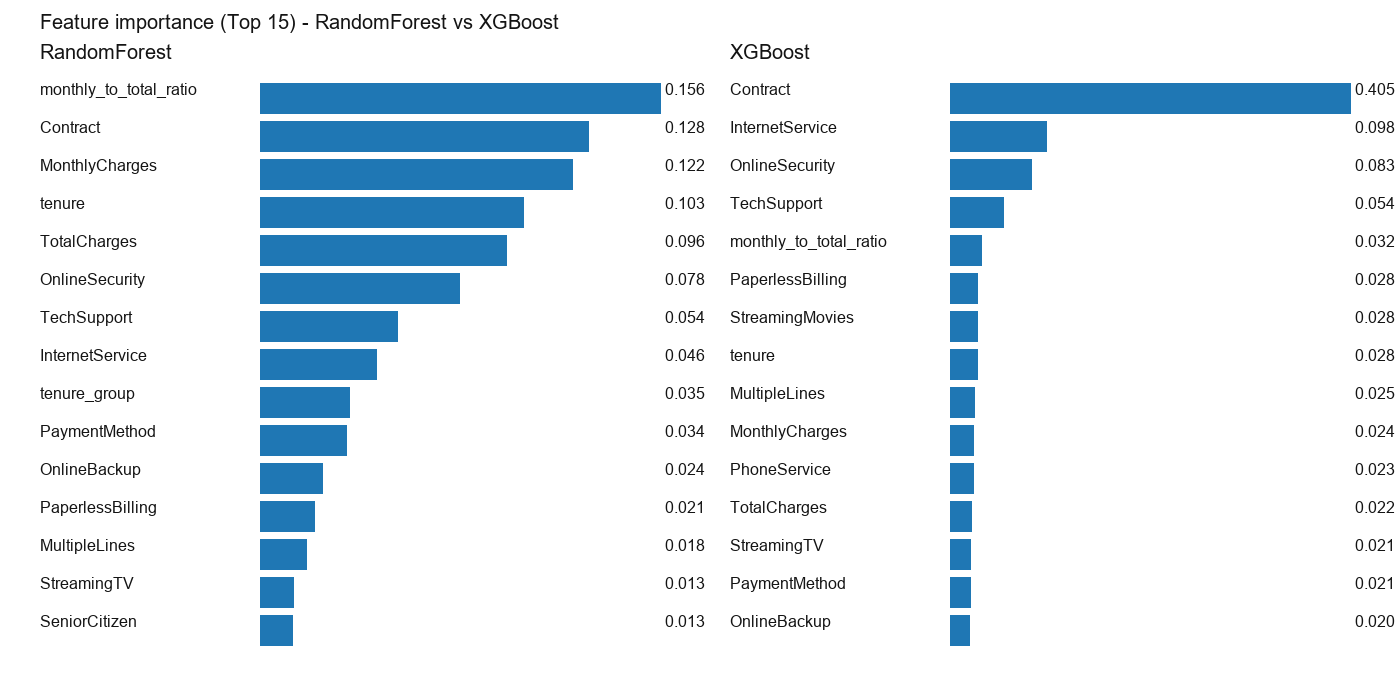

In [15]:
evaluator.save_metrics_json(RESULTS_DIR / 'model_metrics.json')
evaluator.plot_confusion_matrices(RESULTS_DIR / 'confusion_matrix.png')
'Saved metrics + confusion matrix.'


'Saved metrics + confusion matrix.'

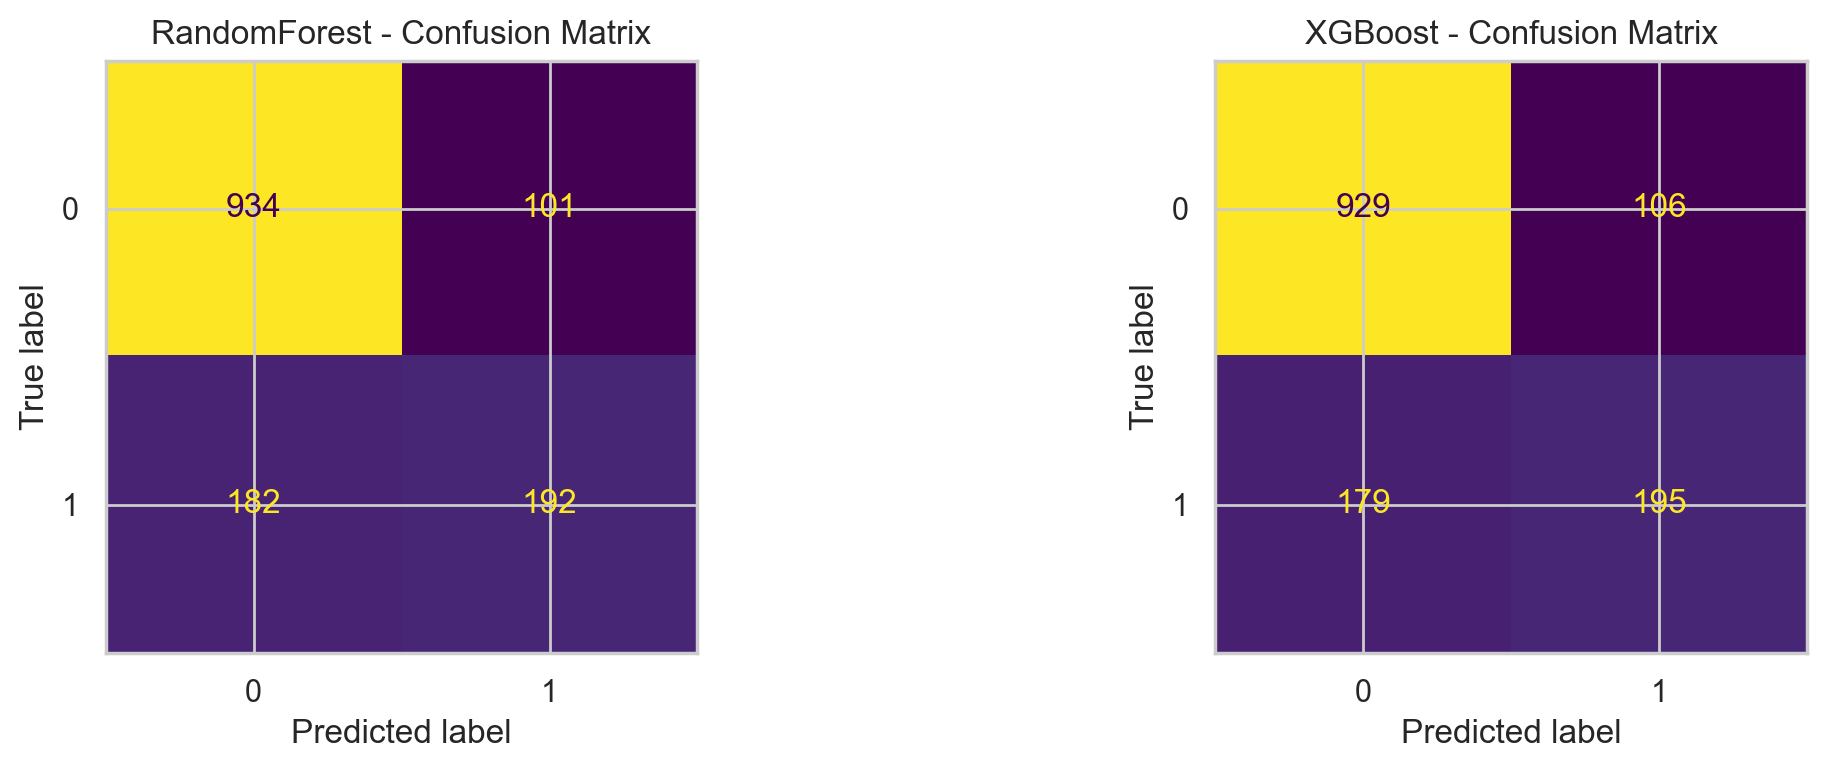

## 8) Mini-exercice (seuils de décision) : 0.3 / 0.5 / 0.7

Idée : le modèle produit une probabilité `p(churn=1)`. Le seuil (par défaut 0.5) transforme cette probabilité en classe 0/1. En business, choisir un seuil plus bas augmente le **recall** (tu rates moins de churners) mais baisse souvent la **precision** (plus de faux positifs).

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = [0.3, 0.5, 0.7]
rows = []

for model_name, model in trained.models.items():
    proba = model.predict_proba(prepared.X_test)[:, 1]
    for t in thresholds:
        y_pred_t = (proba >= t).astype(int)
        rows.append({
            "model": model_name,
            "threshold": t,
            "precision": float(precision_score(prepared.y_test, y_pred_t)),
            "recall": float(recall_score(prepared.y_test, y_pred_t)),
            "f1": float(f1_score(prepared.y_test, y_pred_t)),
            "predicted_positive_rate": float(y_pred_t.mean()),
        })

threshold_report = pd.DataFrame(rows).sort_values(["model", "threshold"])
threshold_report

,model,threshold,precision,recall,f1,predicted_positive_rate
0,RandomForest,0.3,0.530612,0.764706,0.626506,0.382541
1,RandomForest,0.5,0.655290,0.513369,0.575712,0.207949
2,RandomForest,0.7,0.801980,0.216578,0.341053,0.071682
3,XGBoost,0.3,0.539924,0.759358,0.631111,0.373314
4,XGBoost,0.5,0.647841,0.521390,0.577778,0.213627
5,XGBoost,0.7,0.780488,0.256684,0.386318,0.087296


## Analyse du tableau de seuils (impact “métier”)

On a maintenant une preuve claire que le seuil = décision business.

Lecture rapide (les tendances)
- À 0.3 (RF et XGB)
  - Recall ~ 0.76 : on détecte beaucoup plus de churners (plus de faux négatifs/désabonnements)
  - Precision ~ 0.53–0.54 : on a plus de faux positifs (“alarms” des non-churners)
  - Predicted_positive_rate ~ 0.37–0.38 : on va cibler ~37–38% des clients (campagne plus large/coûteuse)

- À 0.5 (seuil standard)
  - Recall ~ 0.51–0.52 : on rate ~48% des churners
  - Precision ~ 0.65 : meilleure précision
  - Predicted_positive_rate ~ 0.21 : on ne cible que ~21% des clients

- À 0.7
  - Precision ~ 0.78–0.80 : très “safe” (peu de faux positifs)
  - Recall ~ 0.22–0.26 : on rate énormément de churners
  - Predicted_positive_rate ~ 0.07–0.09 : campagne très petite (moins de coût, mais faible couverture)

Recommandation de seuil (en pratique)

- Si le coût de rétention est faible (email/bon d’achat léger) et l'bjectif est de ne pas rater les churners
  - on choisit 0.3 (XGBoost légèrement meilleur en F1 ici : 0.631 vs 0.626)

- Si l'action de rétention est coûteuse (appel humain, grosse remise), et on veut minimiser les faux positifs
  - on choisit 0.7

- Si on veut un compromis sans hypothèses business
  - on pourrais garder 0.5, mais le tableau montre que 0.3 donne un meilleur F1 sur les deux modèles → donc souvent meilleur compromis “global”.
  
➡️ Conclusion : 0.3 est le meilleur choix “apprentissage + performance” sur le run actuel, si on accepte une campagne plus large.